# Minimax Game

There is a vehicle with many vulnerabilities in it.  
Each vulnerability has:
- a cost to attack
- a cost to defend
- a probability of successfully attacking
- a probability of successfully defending
- a severity if an attack is successful

Two players
- defender
- attacker

It's a simultaneous-play one-shot game; each player picks an action at the same then the game is over.

The actions in this game are simply selection of vulnerabilities to attack or defend.
The players have a budget which constrains the actions they can take.

In [4]:
# lets try and stay type-safe :P
from typing import *
import random
from dataclasses import dataclass, field

In [25]:
@dataclass(frozen=True)
class Vulnerability: # this could probably be a dataclass
    id: int
    attackerCost: int = field(default_factory=lambda: random.randint(1,5))
    defenderCost: int = field(default_factory=lambda: random.randint(1,5))
    attackerProb: float = field(default_factory=lambda: round(random.uniform(0.05,0.98),2))
    defenderProb: float = field(default_factory=lambda: round(random.uniform(0.05,0.98),2))
    severity: int = field(default_factory=lambda: random.randint(1,5))
    

In [26]:
Vulnerability(123)

Vulnerability(id=123, attackerCost=4, defenderCost=5, attackerProb=0.82, defenderProb=0.25, severity=5)

In [31]:
@dataclass(frozen=True)
class Vehicle:
    vulns: List[Vulnerability] = field(default_factory=list)
    
    @staticmethod
    def get_random_vehicle(num_vulns: int) -> Vehicle:
        return Vehicle(vulns=[Vulnerability(x) for x in range(num_vulns)])

In [32]:
Vehicle.get_random_vehicle(4)

Vehicle(vulns=[Vulnerability(id=0, attackerCost=3, defenderCost=2, attackerProb=0.87, defenderProb=0.74, severity=5), Vulnerability(id=1, attackerCost=2, defenderCost=1, attackerProb=0.43, defenderProb=0.25, severity=5), Vulnerability(id=2, attackerCost=1, defenderCost=2, attackerProb=0.46, defenderProb=0.65, severity=5), Vulnerability(id=3, attackerCost=1, defenderCost=4, attackerProb=0.31, defenderProb=0.09, severity=5)])

helper function for powerset; gets all subsets of a list

In [33]:
T = TypeVar("T")
def powerset(s: List[T]) -> List[List[T]]:
    import itertools
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1, len(s)+1))

In [36]:
list(powerset(range(4)))

[(0,),
 (1,),
 (2,),
 (3,),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 2),
 (1, 3),
 (2, 3),
 (0, 1, 2),
 (0, 1, 3),
 (0, 2, 3),
 (1, 2, 3),
 (0, 1, 2, 3)]

Utility is calculated according to 

$$

                    \begin{equation}
                        U^a(a^a, a^d) := 
                        \sum_{v_k \in a^a}
                        \begin{cases}
                        (1-p^d_k)*p^a_k*s_k^2 & v_k \in a^d \\
                        p^a_k*s_k^2 & v_k \notin a^d \\
                        \end{cases}
                    \end{equation}
$$

In [37]:
def get_attacker_utility(
    defending: List[Vulnerability],
    attacking: List[Vulnerability]
) -> float:
    defendingLookup = set([x.id for x in defending])
    rtn = 0
    for v in attacking:
        if v.id in defendingLookup:
            rtn += (v.severity ** 2) * v.attackerProb * (1-v.defenderProb)
        else:
            rtn += (v.severity ** 2) * v.attackerProb
    return rtn

Solution container class, calculates the probability of a compromise occurring for each severity 1-5

In [38]:
class SubgameSolution:
    defender_util: int
    severity_chances: List[float]
    dchoice: List[Vehicle]
    achoice: List[Vehicle]
    def __init__(self, dchoice: List[Vulnerability], achoice: List[Vulnerability]) -> None:
        self.dchoice = dchoice
        self.achoice = achoice
        self.defender_util = round(-get_attacker_utility(dchoice, achoice),2)
        # Start off as the chance that it is not compromised
        self.severity_chances = {
            1:1,
            2:1,
            3:1,
            4:1,
            5:1
        }
        defendingLookup = set([x.id for x in dchoice])
        for vuln in achoice:
            # Decrease the chance it is not compromised by the chance the attacks fail
            if vuln.id in defendingLookup:
                self.severity_chances[vuln.severity] *= 1-(vuln.attackerProb * (1-vuln.defenderProb))
            else:
                self.severity_chances[vuln.severity] *= 1-(vuln.attackerProb)

        # Convert to the chance that a compromise with the given severity is _successful_
        for k in self.severity_chances.keys():
            self.severity_chances[k] = round(1 - self.severity_chances[k],2)

Solver function, takes a game and returns the optimal solution.

Expected attacker utility: 
$$

                    \begin{equation}
                        U^a_{expected} := \max_{a^a \in \mathcal{A}^a} \min_{a^d \in \mathcal{A}^d} U^a(a^a, a^d)
                    \end{equation}
$$

In [110]:
def get_optimal_actions(
    vehicle: Vehicle,
    attacker_budget: int,
    defender_budget: int,
) -> SubgameSolution:
    action_space = list(powerset(vehicle.vulns))

    # track best possible defender action seen so far
    best_defender_util = -1e100
    best_defender_subset = None
    best_attacker_subset = None

    # For each possible defender action
    for dchoice in action_space:
        # If the defender's budget is exceeded, action isn't legal
        if sum([x.defenderCost for x in dchoice]) > defender_budget: continue

        # track best possible attacker response seen so far
        temp_best_attacker_util = 0
        temp_best_attacker_subset = None
        # For each possible attacker action
        for achoice in action_space:
            # If the attacker's budget is exceeded, action isn't legal
            if sum([x.attackerCost for x in achoice]) > attacker_budget: continue

            # get the utility for the chosen actions
            attacker_util = get_attacker_utility(dchoice, achoice)
            # if it's better for the attacker, update the best attacker response
            if attacker_util > temp_best_attacker_util:
                temp_best_attacker_util = attacker_util
                temp_best_attacker_subset = achoice

        # Defender utility is negative of attacker util; zero-sum game
        defender_util = -1 * temp_best_attacker_util
        # if it's better for the defender, update the best defender action
        if defender_util > best_defender_util:
            best_defender_util = defender_util
            best_defender_subset = dchoice
            best_attacker_subset = temp_best_attacker_subset
    return SubgameSolution(best_defender_subset, best_attacker_subset)

In [111]:
vehicle = Vehicle.get_random_vehicle(8)

In [112]:
vehicle.vulns

[Vulnerability(id=0, attackerCost=5, defenderCost=3, attackerProb=0.2, defenderProb=0.19, severity=3),
 Vulnerability(id=1, attackerCost=4, defenderCost=5, attackerProb=0.32, defenderProb=0.08, severity=5),
 Vulnerability(id=2, attackerCost=2, defenderCost=1, attackerProb=0.82, defenderProb=0.64, severity=3),
 Vulnerability(id=3, attackerCost=2, defenderCost=3, attackerProb=0.55, defenderProb=0.16, severity=1),
 Vulnerability(id=4, attackerCost=1, defenderCost=4, attackerProb=0.96, defenderProb=0.39, severity=4),
 Vulnerability(id=5, attackerCost=1, defenderCost=4, attackerProb=0.47, defenderProb=0.74, severity=4),
 Vulnerability(id=6, attackerCost=3, defenderCost=4, attackerProb=0.33, defenderProb=0.81, severity=2),
 Vulnerability(id=7, attackerCost=1, defenderCost=5, attackerProb=0.38, defenderProb=0.34, severity=2)]

In [114]:
action_space = list(powerset(vehicle.vulns))
# preview utility for some arbitrary actions
get_attacker_utility(action_space[15], action_space[222])

21.4068

In [118]:
solution = get_optimal_actions(vehicle, attacker_budget=10, defender_budget=10)
print("defender utility:", solution.defender_util)
print("compromise probability for each severity:", solution.severity_chances)
print("\nVulnerabilities and actions taken:")
for v in vehicle.vulns:
    print(v, end="\t")
    if v in solution.dchoice:
        print("D", end="\t")
    else:
        print("\t", end="")
    if v in solution.achoice:
        print("A", end="")
    print()

defender utility: -23.5
compromise probability for each severity: {1: 0, 2: 0.38, 3: 0.3, 4: 0.64, 5: 0.32}

Vulnerabilities and actions taken:
Vulnerability(id=0, attackerCost=5, defenderCost=3, attackerProb=0.2, defenderProb=0.19, severity=3)		
Vulnerability(id=1, attackerCost=4, defenderCost=5, attackerProb=0.32, defenderProb=0.08, severity=5)		A
Vulnerability(id=2, attackerCost=2, defenderCost=1, attackerProb=0.82, defenderProb=0.64, severity=3)	D	A
Vulnerability(id=3, attackerCost=2, defenderCost=3, attackerProb=0.55, defenderProb=0.16, severity=1)		
Vulnerability(id=4, attackerCost=1, defenderCost=4, attackerProb=0.96, defenderProb=0.39, severity=4)	D	A
Vulnerability(id=5, attackerCost=1, defenderCost=4, attackerProb=0.47, defenderProb=0.74, severity=4)	D	A
Vulnerability(id=6, attackerCost=3, defenderCost=4, attackerProb=0.33, defenderProb=0.81, severity=2)		
Vulnerability(id=7, attackerCost=1, defenderCost=5, attackerProb=0.38, defenderProb=0.34, severity=2)		A


Format as a LaTeX table, should look something like this when rendered (tho the numbers will be different):

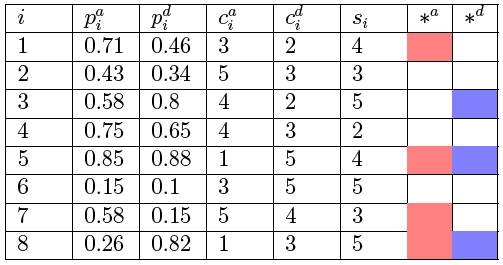

In [86]:
# format for LaTeX table
# this will render properly with used in a full LaTeX document, the but lightweight stuff used with Jupyter doesn't like it :(
template = r"""
\begin{table}
    \centering
    \begin{tabular}{|p{8mm}|p{8mm}|p{8mm}|p{8mm}|p{8mm}|p{8mm}|p{4mm}|p{4mm}|}
        \hline
        $i$ & $p^a_i$ & $p^d_i$ & $c^a_i$ & $c^d_i$ & $s_i$ & $*^a$ & $*^d$ \\
        \hline
        %BODY%
    \end{tabular}
    \caption{Example set of vulnerabilities in the minimax game with parameters $\zeta^a=\zeta^d=10$, $n$=8. The coloured cells represent inclusion in the optimal strategy, with red representing the attacker's optimal strategy and blue representing the defender's optimal strategy.}
    \label{tab:vulnexample}
\end{table}
"""
body = ""
for v in vehicle.vulns:
    body += f"{v.id+1} & {v.attackerProb} & {v.defenderProb} & {v.attackerCost} & {v.defenderCost} & {v.severity} & "
    if v in solution.achoice:
        body += r"\cellcolor{red!50} & "
    else:
        body += "& "
    if v in solution.dchoice:
        body += r"\cellcolor{blue!50}"
    body += "\\\\\n\t\\hline\n\t"
table = template.replace("%BODY%", body.rstrip())
print(table)


\begin{table}
    \centering
    \begin{tabular}{|p{8mm}|p{8mm}|p{8mm}|p{8mm}|p{8mm}|p{8mm}|p{4mm}|p{4mm}|}
        \hline
        $i$ & $p^a_i$ & $p^d_i$ & $c^a_i$ & $c^d_i$ & $s_i$ & $*^a$ & $*^d$ \\
        \hline
        1 & 0.96 & 0.58 & 4 & 5 & 5 & \cellcolor{red!50} & \cellcolor{blue!50}\\
	\hline
	2 & 0.71 & 0.84 & 2 & 1 & 5 & & \cellcolor{blue!50}\\
	\hline
	3 & 0.78 & 0.82 & 4 & 3 & 1 & & \\
	\hline
	4 & 0.81 & 0.46 & 4 & 1 & 4 & & \cellcolor{blue!50}\\
	\hline
	5 & 0.2 & 0.24 & 5 & 2 & 2 & & \\
	\hline
	6 & 0.82 & 0.81 & 1 & 3 & 1 & & \\
	\hline
	7 & 0.82 & 0.53 & 5 & 3 & 5 & \cellcolor{red!50} & \cellcolor{blue!50}\\
	\hline
	8 & 0.42 & 0.81 & 1 & 3 & 4 & \cellcolor{red!50} & \\
	\hline
    \end{tabular}
    \caption{Example set of vulnerabilities in the minimax game with parameters $\zeta^a=\zeta^d=10$, $n$=8. The coloured cells represent inclusion in the optimal strategy, with red representing the attacker's optimal strategy and blue representing the defender's optimal s

# Lets explore the solution space

In [87]:
solutions: List[SubgameSolution] = []

sample 1000 random games and find the solutions

In [88]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

for i in tqdm(range(1000 - len(solutions))): # idempotent
    s = get_optimal_actions(Vehicle.get_random_vehicle(8), 10, 10)
    solutions.append(s)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [96]:
solutions = sorted(solutions, key=lambda x: x.defender_util, reverse=True)
print("The best and worst games for the defender")
for s in [solutions[0], solutions[-1]]:
    print(f"defender util={s.defender_util}", s.severity_chances)

The best and worst games for the defender
defender util=-2.51 {1: 0.92, 2: 0.25, 3: 0, 4: 0, 5: 0}
defender util=-61.21 {1: 0, 2: 0, 3: 0, 4: 0.43, 5: 0.98}


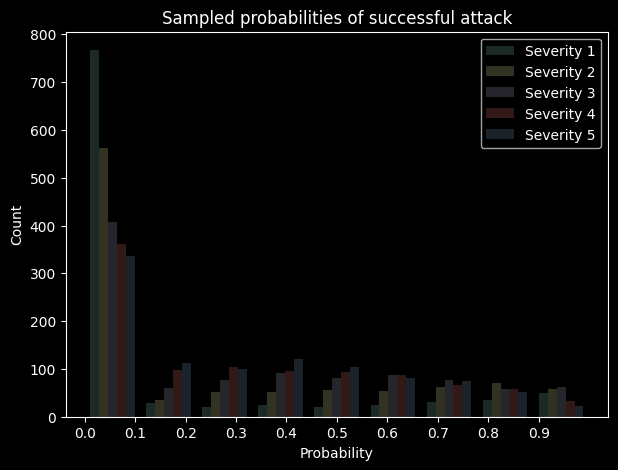

In [106]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({"figure.figsize":(7,5), "figure.dpi":100})

bins = np.linspace(0,1,10)

plt.hist([[s.severity_chances[i] for s in solutions] for i in range(1,6)], bins, alpha=0.2, label=[f"Severity {i}" for i in range(1,6)])
# plt.hist(human, bins, alpha=0.5, label="human")
# plt.hist(ai, bins, alpha=0.5, label="ai")
plt.xticks(np.arange(0,1,0.1))
plt.legend(loc="upper right")
plt.title(f"Sampled probabilities of successful attack")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()
# plt.gca().set(title="Freq histogram", ylabel="Freq")

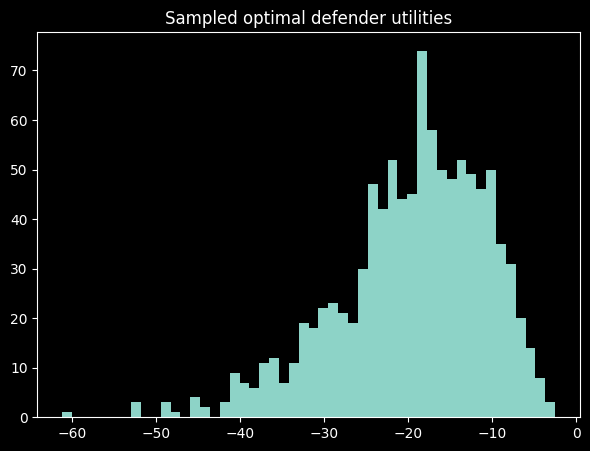

In [101]:
plt.hist([s.defender_util for s in solutions], bins=50)
plt.title("Sampled optimal defender utilities")
plt.show()

Write to JSON for use in other stuff

In [109]:
import json
with open("minimax-game-solutions.json","w") as f:
    json.dump(solutions, f, default=vars, indent=4)